## New Horizons MVIC ring calibration

The idea of this file is to do conversion between the DN limit seen by NH in the MVIC outbound ring images, and physical properties of the ring (such as I/F, tau, and equivalent width).

A few basic parameters of the MVIC outbound search (using `O_RINGDEP_MVICFRAME_305` as an example):
+ Ring opening angle (i.e., sub-observer latitude) = $43 \deg$
+ Date: P+110d = 2015-Nov-01
+ MVIC framing, 1x1, stacked
+ Phase angle $\phi = 165 \deg$
+ Total integration time: 30 sec/pixel (check this)
+ Region covered: 0 .. 105 $R_H$
+ Typical ring upper-limit signal: 0.03 DN per pixel

Various photometric equations and quantities. Not all of these are used here, but they are here for reference and completeness.
+ $\alpha$ = phase angle (forward = $180 \deg$).
+ $\theta$ = scattering angle (forward = $0 \deg$).
+ $P(\alpha)$ = particle phase function, computed from Mie scattering or otherwise. Normalized s.t. $\int_0^\pi P(\theta) \sin \theta d \theta = 2$. (TE98 eq 16).
+ $\tau$ = normal optical thickness.
+ $e$ = emission angle (measured from normal).
+ $B = 90-e$ = elevation angle (measured from equator). Same as sub-observer latitude.
+ $\mu$ = $\cos(e)$
+ $\varpi$ = single-scattering albedo.
+ $R$ = ring radius
+ `RSOLAR  = 100190.64   (DN/s)/(erg/cm^2/s/Ang/sr), Solar spectrum` -- calibration constant from MVIC FITS headers for extended sources (size > 1 pixel) (FITS header literal)
+ `PSOLAR  = 2.5541E+14  (DN/s)/(erg/cm^2/s/Ang), Solar spectrum` -- same as above, but for unresolved. (FITS header literal)
+ F = solar flux, in erg/cm2/s/Ang (NH ICD @ 63)
+ `I = DN / TEXP / RSOLAR = (DN/sec) / RSOLAR`, for `I` in erg/cm2/s/Ang/sr. DN is the signal in a pixel. (NH ICD @ 62)
+ `F = DN / TEXP / PPLUTO = (DN/sec) / PPLUTO` -- flux from an unresolved stellar source, in erg/cm2/s/Ang. DN is the signal in one PSF. (NH ICD @ 64)
+ $I/F$ = normalized reflectance of the ring, where $I$ is measured at the detector, and $\pi F$ is the incident solar flux. (TPW04 @ 63)
+ $EW = \int {I\over F} dR$ -- Equivalent Width. Units of length.
+ $\left( {I \over F} \right)_{rad} = {EW \over {\Delta R}} = {1\over{\Delta R}}\int{I\over F} dR$.  Radially averaged normal $I/F$ of the ring (TE98 eq 12).
+ $4 \mu {I\over F} = \tau \varpi P(\alpha)$. This is the quantity we usually plot (TPW @ 63).
+ ${I\over F} = {{\tau \varpi P(\alpha)}\over {4 \mu}}$. Normal $I/F$ (i.e., I/F that would be measured from directly above the ring, with phase angle preserved). (TPW04 eq 1 @ 63)



The method here is this:
+ Measure DN upper-limit from the images.
+ Look up solar flux, and convert to flux at Pluto's distance.
+ Convert from DN to $I/F$ using the `RSOLAR` constant from the FITS header. We assume that the ring is spatially extended -- that is, it fills the pixels.
+ Use this to measure $\tau \varpi_0 P$.
+ Use this to get optical depth $\tau$.
+ Assume a phase function $P_{11}(\alpha)$ to get an optical depth $\tau$.

## Initialize settings and files

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy
from   astropy.io import fits
import math
import spiceypy as sp
import astropy.units as u
import astropy.constants as c

dir = '/Users/throop/Data/NH_MVIC_Ring/'
file_ring = dir + 'ringdep_mos_v1_wcs_header_pl.fits' # This is Tod's mosaic image

d2r = 2*math.pi / 360.
r2d = 1/d2r

# Define the latitude of the observer. Usually we will look it up from SPICE.

lat_obs = 43.2  # Sub-observer latitude, in degrees

# Define the upper-limit brightness that I found for the ring, in DN

dn_ring = 0.03

## Open file and read header

In [40]:
# Open file
hdulist = fits.open(file_ring)

# Read exposure parameters and constants from the FITS header

exptime      = float(hdulist['PRIMARY'].header['EXPTIME']) # Exposure time. This is per image (before stacking)
pixfov       = float(hdulist['PRIMARY'].header['PIXFOV'])# 19.8065   # Plate scale in microrad/pix
rsolar       = float(hdulist['PRIMARY'].header['RSOLAR']) # 100190.64. # (DN/s)/(erg/cm^2/s/Ang/sr)
                         # RSOLAR is conversion for solar spectrum. Use for resolved sources.    

In [41]:
hdulist['PRIMARY'].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2250                                                  
NAXIS2  =                 5000                                                  
EXTEND  =                    T                                                  
COMMENT Original key: "CRVAL1"                                                  
_RVAL1  =  1.0000000000000E+00                                                  
COMMENT Original key: "CRVAL2"                                                  
_RVAL2  =  1.0000000000000E+00                                                  
COMMENT Original key: "CDELT1"                                                  
_DELT1  =  1.0000000000000E+00                                                  
COMMENT Original key: "CDELT

## Now do a check of this conversion for a region of SP on Pluto

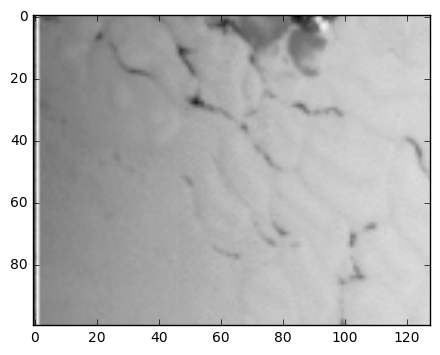

In [43]:
file = dir + 'mpf_0299175045_0x548_sci_1.fit' # Define an MVIC Pan Frame image

hdu_sp = fits.open(file)
header = hdu_sp['PRIMARY'].header

exptime = float(header['EXPTIME'])
rpluto  = float(header['RPLUTO']) # (DN/s)/(erg/cm^2/s/Ang/sr), Pluto spectrum  
rsolar  = float(header['RSOLAR']) # (DN/s)/(erg/cm^2/s/Ang/sr), Solar spectrum 
ppluto  = float(header['PPLUTO'])
pixfov  = float(header['PIXFOV'])

im_sp = hdu_sp['PRIMARY'].data
im_spe = (np.transpose(im_sp[0,:,2700:2800]))  # Extract of SP image

plt.imshow(im_spe, cmap = 'Greys_r')
plt.show()

dn_sp = np.median(im_spe)  # Calculate the median value of this region of SP, in DN

# iof_sp = dn2iof(dn_sp, exptime, pixfov, rpluto) # Convert from DN to I/F

iof_sp_known = 0.6 # From fig. 1F of Nature paper: max of (I/F)_sp ~ 0.6


In [44]:
# print("Pluto surface: DN = {:.2f}, I/F = {:.2f}.".format(dn_sp, iof_sp))

In [45]:
exptime

0.5

In [46]:
rpluto

96376.62

In [47]:
rsolar

100190.64

In [48]:
    f_solar_1au_si     = 1.77                 # W/m2/nm. At 600 nm. 
    f_solar_1au_cgs    = f_solar_1au_si * 100 # Convert from W/m2/nm to erg/sec/cm2/Angstrom
                                              # Unit conversion is correct -- see python code below.

    f_solar_1au        = f_solar_1au_cgs

    r_pluto            = 33.8                 # Pluto solar distance, in AU
    
    # Calculate the solar flux at Pluto's distance.

    f_solar_pluto       = f_solar_1au / (r_pluto**2)  # Use 1/r^2

In [49]:
f_solar_pluto

0.1549315500157558

# Now do this all a simpler way, based on Hal's LORRI writeup from 2008.

In [50]:
RPLUTO = rpluto

In [51]:
C = 0.03 # DN value from my analysis

In [52]:
TEXP = 0.5 # Exposure length

### Define the solar flux, from Hal's paper.

In [53]:
F_solar = 176 # Flux from Hal's paper

### Calculate the Pluto-Sun distance, in AU (or look it up)

In [54]:
r = 33.8 # Distance in AU

### Calculate intensity, from Hal's paper

In [55]:
I = C / TEXP / RPLUTO

### Apply Hal's conversion formula from p. 7, to compute I/F and print it.

In [56]:
IoF = math.pi * I * r**2 / F_solar # Equation from Hal's paper

In [57]:
IoF

1.2695510371778691e-05

## Now convert to 'normal I/F'

### Define $\mu$, the ring opening angle.

In [58]:
mu = math.cos(lat_obs / 57)


### Calculate the normal I/F

In [59]:
IoF_normal = 4 * mu * IoF

In [130]:
dist = math.sqrt(header['SPCTSOX']**2 + header['SPCTSOY']**2 + header['SPCTSOZ']**2)*u.km.to('AU') # Convert km → AU

In [61]:
IoF_normal

3.688222303328049e-05

## Now do LORRI calibration

### Read in the LORRI mosaic file, created by Tod. 
Units in this image are unchanged from the original FITS files. They are DN, and they are averaged (not summed).

In [118]:
file = '/Users/throop/Data/NH_LORRI_Ring/o_ring_202/ring_lor202_mos_header_v1.fits'
hdulist = fits.open(file)

### Read the header keywords to get the calibration constants and other quantities

In [140]:
header = hdulist['PRIMARY'].header
# Get some FITS keywords. We could also get CCDGAIN, RDNOISE, etc.
EXPTIME = header['EXPTIME'] # Usually 200ms or 400 ms. Not sure what the difference is
# RSOLAR  = header['RSOLAR']  # Conversion constant for unresolved sources. 
                            # RSOLAR = 2.664E+05 (DN/s)/(erg/cm^2/s/Å/sr) [in Hal's paper]
                            # RSOLAR = 5.1E+06                            [in FITS header]
                            # Not sure what the difference here is due to?
RSOLAR = 3800640.0          # For 4x4, as per Hal e-mail 7-Dec-2016. Do NOT use FITS header keywords.
                            # They are not corrected for 4x4, *and* value has changed by ~20%.

dist = math.sqrt(header['SPCTSOX']**2 + header['SPCTSOY']**2 + header['SPCTSOZ']**2) # Distance in km
dist_au = dist*u.km.to('AU') # Convert distance to AU.

F_solar = 176 # Solar flux, in erg/cm2/s/Angstrom. Value from Hal's whitepaper.

### Define the ring brightness limit that I find, in DN

In [141]:
dn_ring = 1 # Typical scatter in binned DN values in the LORRI mosaic images.

### Do the conversion from DN to I/F, following Hal's paper

In [142]:
I = dn_ring/EXPTIME/RSOLAR
IoF = math.pi * I * dist_au**2 / F_solar
IoF_normal = 4 * mu * IoF

### Print the results to a table

In [143]:
print("LORRI Ring limit")
print("Image = " + file.split('/')[-1])
print("UTC = " + header['SPCUTCAL'])
print("Distance = {:.1f} AU".format(dist_au))
print("RSOLAR = " + repr(RSOLAR))
print("EXPTIME = {} sec".format(EXPTIME))
print("mu = cos({} deg) = {:.2e}".format(lat_obs, mu))
print("Ring upper limit = {} DN".format(dn_ring))
print("I/F = {:.2e}".format(IoF))
print("Normal I/F = {:.2e}".format(IoF_normal))

LORRI Ring limit
Image = ring_lor202_mos_header_v1.fits
UTC = 2015-07-21T13:00:00.663
Distance = 32.9 AU
RSOLAR = 5114880.0
EXPTIME = 0.4 sec
mu = cos(43.2 deg) = 7.26e-01
Ring upper limit = 1 DN
I/F = 9.45e-06
Normal I/F = 2.75e-05


In [144]:
header

SIMPLE  =                    T / Written by IDL:  Fri Jun 10 15:38:03 2016      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  720 / Number of positions along axis 1               
NAXIS2  =                 1560 / Number of positions along axis 2               
EXTEND  =                    T                                                  
MISSION = 'New Horizons'       / Mission name                                   
HOSTNAME= 'NEW HORIZONS'       / Host name (PDS terminology)                    
HOSTID  = 'NH      '           / Host ID (PDS terminology)                      
INSTRU  = 'lor     '           / Instrument                                     
APID    = '0x633   '           / Application ID of science data                 
MET     =            299789519 / First packet MET (from instrument or HS bus)   
METEND  =            2997895

In [138]:
RSOLAR

3800640.0

In [139]:
RPLUTO

4944000.0

In [145]:
header['RSOLAR'] /3800640

1.3457943925233644